### DWT Based Image Encoding

Use qsp_main6

MedMNIST https://medmnist.com/

In [1]:
from matplotlib import pyplot as plt
import pickle as pkl

import quimb.tensor as qtn

from qsp.misc_states import make_aklt_mps
from qsp.misc_states import make_aklt_peps
from qsp.tsp import MPSPreparation, PEPSPreparation
from qsp.tsp_helper_routines import make_splitted_mps

from qiskit import Aer, execute

import numpy as np
from PIL import Image
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import math

import pywt
import matplotlib.pyplot as plt

from medmnist import ChestMNIST

c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\cotengra\hyperoptimizers\hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\qsp\tsp.py:10: FutureWarning: The `qiskit` package is not installed, only `qiskit-terra` is installed. Starting in Qiskit 1.0.0 only the `qiskit` package will be published. Migrate any requirements files still using `qiskit-terra` to use `qiskit` instead. See https://qisk.it/1-0-packaging-migration for more detail.
  import qiskit


#### Generate method: Take image -> compute 2d DHWT -> Flatten into state vector -> Construct MPS -> Encode -> Take simulated output, compute fidelity and reconstruct the image

Essential Helper Functions

In [21]:
# Function to load the image and convert it to grayscale
def load_image_as_grayscale(image_path):
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    return np.array(img)

# Function to perform the 2D wavelet transform and flatten it to a 1D vector
def wavelet_transform_1d(image_array, wavelet='haar', level=None):
    coeffs = pywt.wavedec2(image_array, wavelet=wavelet, level=level)
    coeffs_flattened = []
    coeffs_shapes = []
    
    # Flatten the coefficients into a 1D vector and store their shapes for reconstruction
    for coeff in coeffs:
        if isinstance(coeff, tuple):
            coeffs_shapes.append([subband.shape for subband in coeff])
            for subband in coeff:
                coeffs_flattened.extend(subband.flatten())
        else:
            coeffs_shapes.append(coeff.shape)
            coeffs_flattened.extend(coeff.flatten())
    
    return np.array(coeffs_flattened), coeffs_shapes

# Function to reconstruct the wavelet coefficients from the 1D vector
def reconstruct_wavelet_coeffs_from_1d(wavelet_vector, coeffs_shapes):
    coeffs = []
    index = 0
    for shape in coeffs_shapes:
        if isinstance(shape, list):  # Handle detail coefficients (tuple of arrays)
            sub_coeffs = []
            for sub_shape in shape:
                size = np.prod(sub_shape)  # Total number of elements in this subband
                sub_coeff = np.array(wavelet_vector[index:index+size]).reshape(sub_shape)
                sub_coeffs.append(sub_coeff)
                index += size
            coeffs.append(tuple(sub_coeffs))
        else:  # Handle approximation coefficients
            size = np.prod(shape)
            coeff = np.array(wavelet_vector[index:index+size]).reshape(shape)
            coeffs.append(coeff)
            index += size
    return coeffs

# Function to reconstruct the image from the 1D wavelet vector
def reconstruct_image_from_1d(wavelet_vector, coeffs_shapes, wavelet='haar'):
    # Reconstruct the coefficients
    coeffs = reconstruct_wavelet_coeffs_from_1d(wavelet_vector, coeffs_shapes)
    
    # Perform the inverse wavelet transform to reconstruct the image
    reconstructed_image = pywt.waverec2(coeffs, wavelet=wavelet)
    
    # Clip values to valid image range [0, 255] and convert to uint8
    reconstructed_image = np.clip(reconstructed_image, 0, 255).astype(np.uint8)
    
    return reconstructed_image

def to_pil_image(array):
    array_clipped = np.clip(array, 0, 255)  # Clip values to [0, 255]
    array_uint8 = array_clipped.astype(np.uint8)
    return Image.fromarray(array_uint8)
    

def plot_schmidt_spectrum(y_amp,thresh=1e-16):
        # Calculate number of qubits
    num_qubits = np.log2(y_amp.shape[0])
    assert np.isclose(num_qubits, int(num_qubits)), "Length of y_amp should be a power of 2."
    num_qubits = int(num_qubits)

    # Ensure the number of qubits is even
    assert num_qubits % 2 == 0, "Number of qubits must be even."

    # Define the central bipartition
    central_bond = num_qubits // 2  # Split after central_bond qubits

    # Reshape the amplitude array to separate the two halves
    yamp_unfolded = np.reshape(y_amp, (2**central_bond, 2**central_bond), order='C')

    # Compute Schmidt coefficients via SVD
    singular_values = np.linalg.svd(yamp_unfolded, compute_uv=False)
    s_squared = np.abs(singular_values)**2
    s_squared /= np.sum(s_squared)
    
    j = 0
    for s in singular_values:
        if s>thresh:
            j+=1

    print(f"Num singular values above threshold = {j}")
    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(s_squared, 'o-')
    plt.yscale('log')
    plt.xlabel('Schmidt Coefficient Index')
    plt.ylabel('$\lambda_i^2$')
    plt.title('Schmidt Spectrum')
    plt.grid(True)
    plt.show()

def reverse_bitstring_association(values): #Required to reverse bitstring order from Qiskit circuit output
    # Get the length of the list (n items require bitstrings of log2(n) bits)
    n = len(values)
    bit_length = len(bin(n - 1)) - 2  # Subtract 2 to remove the '0b' prefix from bin()

    # Create a new list to store rearranged values
    rearranged_values = [None] * n

    # Iterate over all the indices and reverse the bitstrings
    for i in range(n):
        # Convert index to binary string and pad with leading zeros
        bitstring = f"{i:0{bit_length}b}"
        
        # Reverse the bit string
        reversed_bitstring = bitstring[::-1]
        
        # Convert the reversed bit string back to an integer index
        reversed_index = int(reversed_bitstring, 2)
        
        # Place the value at the reversed index
        rearranged_values[reversed_index] = values[i]

    return np.array(rearranged_values)

def to_pil_image(array):
    array_clipped = np.clip(array, 0, 255)  # Clip values to [0, 255]
    array_uint8 = array_clipped.astype(np.uint8)
    return Image.fromarray(array_uint8)

Load Dataset and Image Encoding

In [3]:
dataset = ChestMNIST(split="test", download=True, size=128)

100%|██████████| 1426132371/1426132371 [18:52<00:00, 1258812.09it/s]


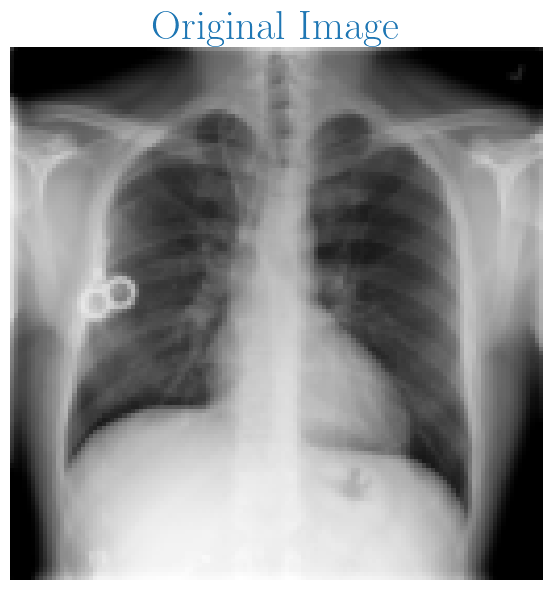

In [23]:
original_image = dataset[0][0]
target_vector = np.array(original_image) #Not normalised

fig, axes = plt.subplots(1, 1, figsize=(18, 6))

# Original Image
axes.imshow(dataset[0][0], cmap='gray')  # Access axes directly since it's not an array
axes.set_title('Original Image')
axes.axis('off')

plt.tight_layout()
plt.show()

Compute Schmidt Decomposition to Visualise Singular Value Decay Rate

Num singular values above threshold = 128


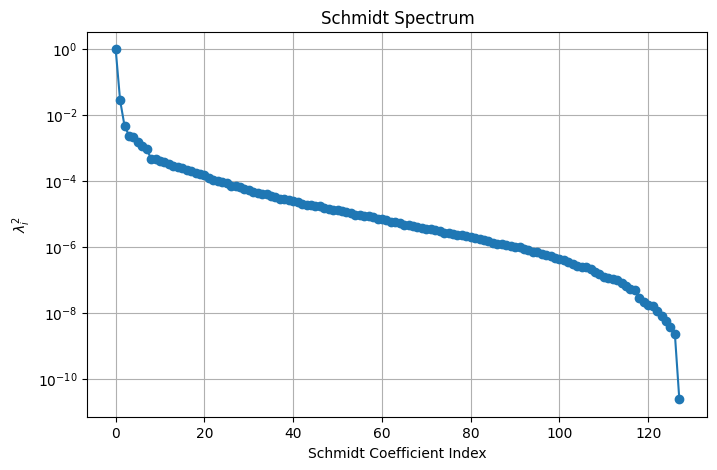

In [14]:
#COMPUTE THE 2D DWT and FLATTEN INTO A VECTOR, VISUALISING THE SINGULAR VALUE DECAY

wavelet_vector, coeffs_shapes = wavelet_transform_1d(target_vector)

plot_schmidt_spectrum(wavelet_vector)

Construct the MPS and Choose Encoding Parameters

In [15]:
#CONSTRUCT MPS

n = 14 #128x128 image

wavelet_vector = np.array(wavelet_vector,dtype=complex)

target_mps = qtn.MatrixProductState.from_dense(wavelet_vector,dims=[2]*n)
target_mps_prep = MPSPreparation(target_mps,shape='lrp')  

In [47]:
#ENCODE MPS

optimise = True

layers = 20

#Note: occasional issues arise with optimisation related to numerical stability. Room to experiment with different optimisers here.

if(optimise):
    overlap, circ = target_mps_prep.sequential_unitary_circuit_optimization(num_var_seq_layers=layers) #can also set max_bond_dim,max_iterations
else:
    overlap, circ = target_mps_prep.sequential_unitary_circuit(num_seq_layers=layers) #can also set max_bond_dim

print(f"The circuit depth is {circ.depth()}")

doing variational optimization over sequential unitaries (num_var_seq_layers=20)...


100%|██████████| 20/20 [00:05<00:00,  3.99it/s]


number of variational params in the circuit (from sequential algorithm) are 6174


c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


overlap before variational optimization = -0.9801517129


-0.987784147263 [best: -0.994157850742] : : 754it [4:12:29, 20.09s/it]                         


overllap after variational optimization = 0.9941578507423401 (from circ 0.9878278664767735),
n_gates=2291, n_2qg=759

The circuit depth is 305


In [61]:
#ENCODE MPS

optimise = False

layers = 300

#Note: occasional issues arise with optimisation related to numerical stability. Room to experiment with different optimisers here.

if(optimise):
    overlap, circ = target_mps_prep.sequential_unitary_circuit_optimization(num_var_seq_layers=layers) #can also set max_bond_dim,max_iterations
else:
    overlap, circ2 = target_mps_prep.sequential_unitary_circuit(num_seq_layers=layers) #can also set max_bond_dim

print(f"The circuit depth is {circ2.depth()}")

preparing mps using sequential unitaries (num_seq_layers=300)...


100%|██████████| 300/300 [09:55<00:00,  1.98s/it]


overlap from static seq. preparation = 0.9980586898339011 (from circ 0.9980588076901868),
n_gates=34931, n_2qg=11639

The circuit depth is 3665


Simulate the Quantum Circuit

In [62]:
#EXECUTE QISKIT CIRCUIT 
encoded_image_vector = execute(circ2, Aer.get_backend('statevector_simulator')).result().get_statevector()

#reverse order of qubit readout for correct response
encoded_image_vector = reverse_bitstring_association(encoded_image_vector)

#rescale so the pixel values are consistent with the original
rescaled_encoded_vector = encoded_image_vector * np.linalg.norm(wavelet_vector)

Visualise the Encoded State Vector

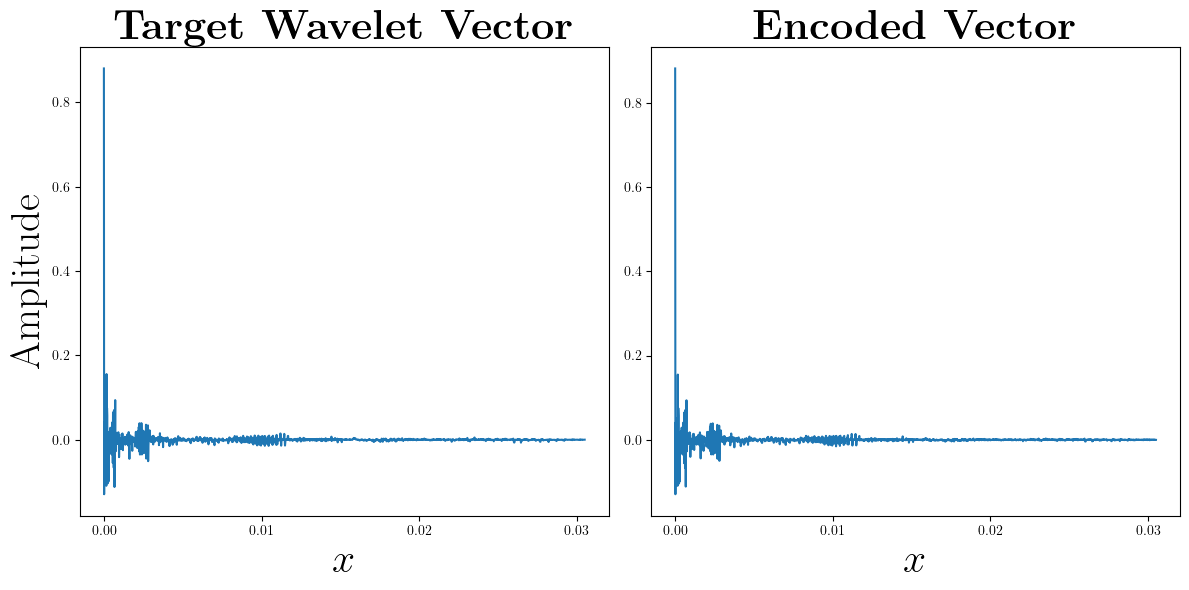

In [84]:
#VISUALISE VECTOR SIMILARITY (note: zoomed into first k data points)

k = 2000
x_data = np.linspace(0, 1, 2**16)[:k]

# Create the side-by-side plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

wave_norm = wavelet_vector / np.linalg.norm(wavelet_vector)
encode_norm = rescaled_encoded_vector / np.linalg.norm(rescaled_encoded_vector)

plt.rcParams.update({
    "text.usetex": True,                    # Use LaTeX for all text
    "font.family": "serif",                 # Use a serif font
    "axes.labelsize": 12,                   # Font size for labels
    "axes.titlesize": 30,                   # Font size for titles
    "xtick.labelsize": 10,                  # Font size for x-ticks
    "ytick.labelsize": 10,                  # Font size for y-ticks
    "figure.figsize": (18, 6),              # Figure size
    "xtick.labelsize": 24,                  # Increased font size for x-ticks
    "ytick.labelsize": 24,   
    "axes.titlecolor": "black",           # Nice shade of blue for titles
    "axes.edgecolor": "black",           # Edge color for axes
    "xtick.color": "black",               # X-tick color
    "ytick.color": "black",               # Y-tick color
    "text.color": "black",                # General text color
    "axes.labelcolor": "black",
})

# Plot wavelet_vector on the first subplot
axes[0].plot(x_data, wave_norm[:k])
axes[0].set_title(r'\textbf{Target Wavelet Vector}',weight='bold')
axes[0].set_ylabel(r"Amplitude",fontsize=30,color="black")
axes[0].set_xlabel(r"$x$",fontsize=30,weight='bold')

# Plot rescaled_encoded_vector on the second subplot
axes[1].plot(x_data, encode_norm[:k])
axes[1].set_title(r'\textbf{Encoded Vector}',weight='bold')
axes[1].set_xlabel(r"$x$",fontsize=30,weight='bold')

# Display the plot
plt.tight_layout()

plt.savefig(r'C:\Users\0josh\OneDrive\Desktop\Re-organised Honours Year\Thesis Documents\Misc. Plots\wavelet_vector_encoding.png', dpi=600, bbox_inches='tight', transparent=True)

plt.show()

Double Check Circuit Fidelity

In [64]:
#Double Check Fidelity

norm_wave = wavelet_vector / np.linalg.norm(wavelet_vector)

norm_enc = rescaled_encoded_vector / np.linalg.norm(rescaled_encoded_vector)

print(np.abs(np.vdot(norm_wave, norm_enc))**2)

0.9961213830944182


Visualise Circuit Output

C:\Users\0josh\AppData\Local\Temp\ipykernel_17260\258769804.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  reconstructed_image = np.clip(reconstructed_image, 0, 255).astype(np.uint8)


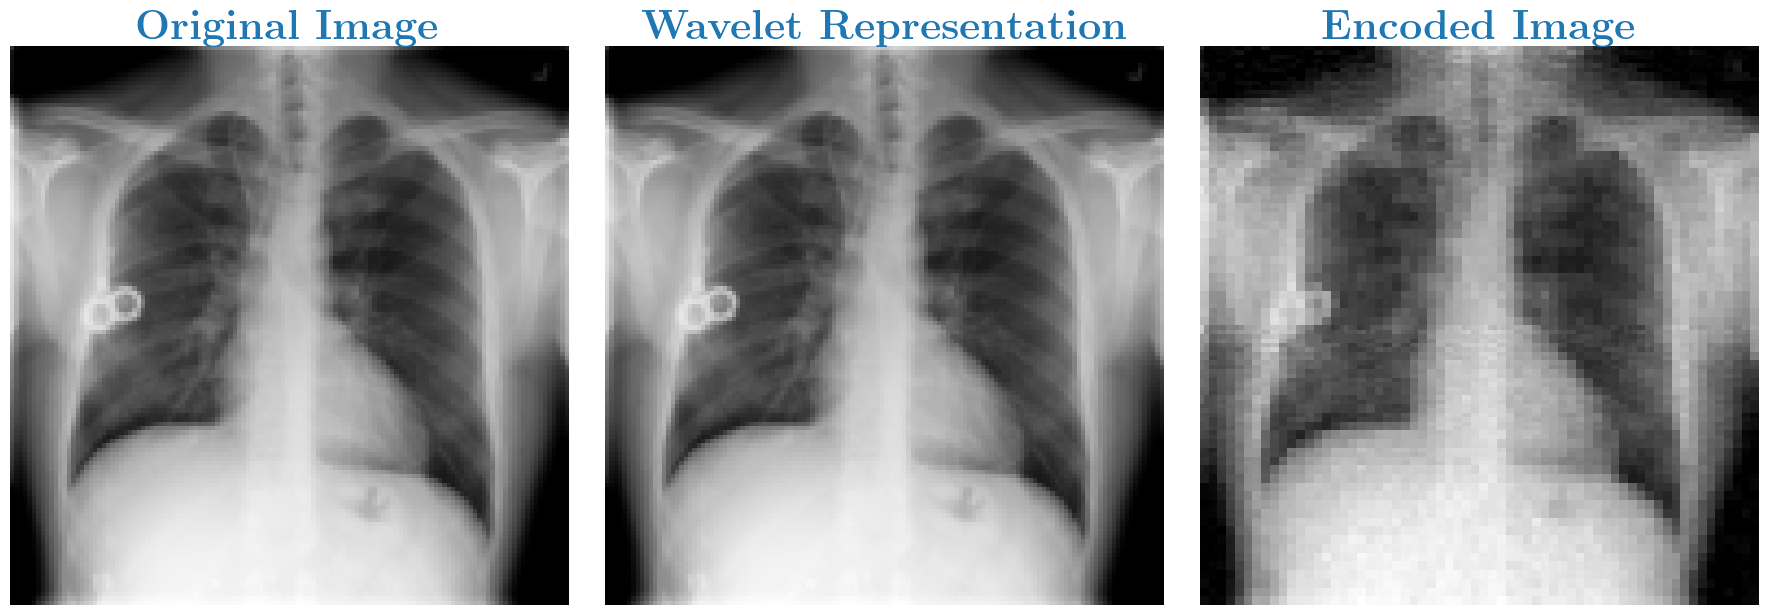

In [80]:
#RECONSTRUCT IMAGES FROM 1D VECTORS

reconstruct_encoded_image = reconstruct_image_from_1d(rescaled_encoded_vector, coeffs_shapes)
reconstructed_wavelet_image = reconstruct_image_from_1d(wavelet_vector, coeffs_shapes)

encoded_image = to_pil_image(reconstruct_encoded_image)
wavelet_image = to_pil_image(reconstructed_wavelet_image)

plt.rcParams.update({
    "text.usetex": True,                    # Use LaTeX for all text
    "font.family": "serif",                 # Use a serif font
    "axes.labelsize": 12,                   # Font size for labels
    "axes.titlesize": 30,                   # Font size for titles
    "xtick.labelsize": 10,                  # Font size for x-ticks
    "ytick.labelsize": 10,                  # Font size for y-ticks
    "figure.figsize": (18, 6),              # Figure size
    "axes.titlecolor": "#1f77b4",           # Nice shade of blue for titles
    "axes.edgecolor": "#1f77b4",            # Edge color for axes
    "xtick.color": "#1f77b4",               # X-tick color
    "ytick.color": "#1f77b4",               # Y-tick color
    "text.color": "#1f77b4",                # General text color
    "axes.labelcolor": "#1f77b4"
})

# Create the side-by-side plot with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original Image
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title(r'\textbf{Original Image}')
axes[0].axis('off')  # Hide axis ticks and labels

# Wavelet Representation
axes[1].imshow(wavelet_image, cmap='gray')
axes[1].set_title(r'\textbf{Wavelet Representation}')
axes[1].axis('off')  # Hide axis ticks and labels

# Reconstructed Image from Rescaled Encoded Vector
axes[2].imshow(encoded_image, cmap='gray')
axes[2].set_title(r'\textbf{Encoded Image}')
axes[2].axis('off')  # Hide axis ticks and labels

# Improve layout
plt.tight_layout()

plt.savefig(r'C:\Users\0josh\OneDrive\Desktop\Re-organised Honours Year\Thesis Documents\Misc. Plots\encoded_image.png', dpi=600, bbox_inches='tight', transparent=True)


# Display the plot
plt.show()